In [1]:
import itertools
import operator
import re
from abc import *
from copy import deepcopy
from operator import itemgetter
from typing import *
import numpy as np
import scipy as sp
import networkx as nx
import mne
import time
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors._dist_metrics import DistanceMetric
from sklearn.utils import shuffle
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from nodestimation.learning.estimation import collect_statistic, \
    compute_importance, collect_cross_statistic, make_selection_map, \
    select, separate_datasets, selected_statistic, choose_best, selected_data, make_feature_selection
from nodestimation.learning.informativeness import CrossInformativeness, Informativeness, SubjectsInformativeness, \
    NodesInformativeness
from nodestimation.learning.networking import sparse_graph, graph_to_hemispheres, hemispheres_division_modularity, \
    metric_for_hemispheres
from nodestimation.processing.features import prepare_features
from nodestimation.project import find_subject_dir, conditions_unique_code
from nodestimation.pipeline import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import nibabel
import nilearn.plotting as nplt
from nodestimation.project.actions import read
import nodestimation as nd
from nodestimation.learning.modification import append_series, promote
import nodestimation.learning.modification as lmd
from nodestimation.project.subject import Subject
from sklearn.preprocessing import *
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import matplotlib as mpl
from nodestimation.learning.selection import SubjectsStatistic, Wilcoxon, Mannwhitneyu, Test
from scipy.stats import wilcoxon, spearmanr, pearsonr
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy.fftpack import fftfreq, irfft, rfft
from scipy.fftpack import fftfreq, irfft, rfft
from sklearn.linear_model import LinearRegression

ENGEL1 = [
    'B1C2',
    'B1R1',
    'G1R1',
    'G1V2',
    'J1T2',
    'K1V1',
    'L1P1',
    'M1G2',
    'M1N2',
    'O1O2',
    'R1D2',
    'S1A2',
    'S1B1',
    'S1H1',
    'S1U3'
]
ENGEL2 = [
    'L2M1',
    'M2S2',
    'N2K2',
    'P1H2'
]
ENGEL3 = [
    'N3S2',
    'S3R1'
]
ENGEL4 = [
    'K4L2'
]
REJECTED = [
    'S1U3',
    'P1H2'
]

AGE = {
    'B1C2': 28.0,
    'B1R1': 16.0,
    'G1R1': 23.0,
    'G1V2': 5.0,
    'J1T2': 8.0,
    'K1V1': 10.0,
    'K4L2': 14.0,
    'L1P1': 16.0,
    'L2M1': 20.0,
    'M1G2': 8.0,
    'M1N2': 7.0,
    'M2S2': 18.0,
    'N2K2': 30.0,
    'N3S2': 10.0,
    'O1O2': 18.0,
    'R1D2': 6.5,
    'P1H2': 7.0,
    'S1A2': 12.0,
    'S1B1': 17.0,
    'S1H1': 28.0,
    'S3R1': 19.0,
    'S1U3': 15.0,
}

SEX = {
    'B1C2': 'f',
    'B1R1': 'm',
    'G1R1': 'f',
    'G1V2': 'm',
    'J1T2': 'f',
    'K1V1': 'f',
    'K4L2': 'f',
    'L1P1': 'f',
    'L2M1': 'f',
    'M1G2': 'm',
    'M1N2': 'm',
    'M2S2': 'm',
    'N2K2': 'm',
    'N3S2': 'm',
    'O1O2': 'f',
    'R1D2': 'f',
    'P1H2': 'm',
    'S1A2': 'm',
    'S1B1': 'm',
    'S1H1': 'm',
    'S3R1': 'm',
    'S1U3': 'f',
}

ENGEL = dict()
for group, i in zip([ENGEL1, ENGEL2, ENGEL3, ENGEL4], range(4)):
    ENGEL.update({
        subject_name: i+1
        for subject_name in group
    })


def distance(point1: np.ndarray, point2: np.ndarray = np.array([0, 0, 0])) -> float:
    return np.sqrt(
        np.sum(
            np.array([
                (coords1 - coords2) ** 2
                for coords1, coords2 in zip(point1, point2)
            ])
        )
    )

def angle(point1: np.ndarray, point2: np.ndarray, center: np.ndarray = np.array([0, 0, 0])) -> np.ndarray:
    a = point1 - center
    b = point2 - center
    return np.degrees(
        np.arccos(
            np.around(
                np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)),
                decimals=8
            )
        )
    )


def spheric_angles(point: np.ndarray, center: np.ndarray = np.array([0, 0, 0])) -> Union[
    Tuple[np.ndarray, np.ndarray], Tuple[float, float]]:
    if all(point != center):
        proj = point.copy()
        proj[2] = center[2]
        axis1 = center.copy()
        axis1[0] = center[0] + 1
        axis2 = center.copy()
        axis2[2] = center[2] + 1
        return angle(proj, axis1, center), angle(point, axis2, center)
    else:
        return 0.0, 0.0

def dfplot(df: pd.DataFrame, col1: str, col2: str, *args, **kwargs) -> None:
    x = df[col1].to_numpy()
    y = df[col2].to_numpy()
    plt.plot(x, y, *args, **kwargs)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

/home/user/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
SUBJECTS = pipeline(
    methods=['wpli', 'envelope', 'coh', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli2_debiased'],
    freq_bands=(4, 8),
    centrality_metrics=['eigen', 'between', 'degree', 'info']
    )

subjects = [subject
            for subject in SUBJECTS
            if subject.name not in REJECTED
            and subject.name in [*ENGEL1, *ENGEL2]
            ]
print(subjects)

All computation has been already done, loading of the existing file with the solution...
[<nodestimation.project.subject.Subject object at 0x7f5e672d6e20>, <nodestimation.project.subject.Subject object at 0x7f5e670a2370>, <nodestimation.project.subject.Subject object at 0x7f5e66d21d90>, <nodestimation.project.subject.Subject object at 0x7f5e66b702e0>, <nodestimation.project.subject.Subject object at 0x7f5e669b37f0>, <nodestimation.project.subject.Subject object at 0x7f5e667f9cd0>, <nodestimation.project.subject.Subject object at 0x7f5e66646220>, <nodestimation.project.subject.Subject object at 0x7f5e6648a730>, <nodestimation.project.subject.Subject object at 0x7f5e662d0c70>, <nodestimation.project.subject.Subject object at 0x7f5e65d1b190>, <nodestimation.project.subject.Subject object at 0x7f5e65adf6d0>, <nodestimation.project.subject.Subject object at 0x7f5e65768130>, <nodestimation.project.subject.Subject object at 0x7f5e653ecb50>, <nodestimation.project.subject.Subject object at 0x7

In [3]:
DATASET = metric_for_hemispheres(subjects, nx.algorithms.global_efficiency)
print('graph done')

graph done


In [4]:
HEMISPHERE = {
    sample[:4]: sample[5:]
    for sample in DATASET.index
    if DATASET.loc[sample]['resected']
}

In [6]:
modularity_env, modularity_wpli = dict(), dict()
freq = '4-8Hz'

for subject in subjects:
    for method in ['wpli', 'envelope']:
        label_names = list(subject.connectomes[freq][method].index)
        mapping = {
            i: label_name
            for i, label_name in zip(
                range(len(label_names)),
                label_names
            )
        }
        G = sparse_graph(
            nx.convert_matrix.from_numpy_matrix(
                subject.connectomes[freq][method].to_numpy()
            )
        )
        G = nx.relabel_nodes(G, mapping)

        modularity = {
            'wpli': modularity_wpli,
            'envelope': modularity_env
        }[method]
        modularity.update({
            # subject.name: hemispheres_division_modularity(G)
            subject.name: nx.algorithms.smetric.s_metric(G, normalized=False)
        })

# print(lmd.dict_to_str(modularity_env))
# print(lmd.dict_to_str(modularity_wpli))

In [5]:
dataset = DATASET.copy()

In [6]:
cross_hemispheres_informativeness = CrossInformativeness()
cross_subjects_informativeness = CrossInformativeness()

for _ in range(100):
    hemispheres_informatoveness = Informativeness()
    subjects_informativeness = SubjectsInformativeness()
    acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

    for i in range(100):

        y = dataset['resected'].to_numpy()
        x = dataset[[f'global_efficiency_for_wpli_4-8Hz', f'global_efficiency_for_envelope_4-8Hz']].to_numpy()

        scaler = StandardScaler()
        x = scaler.fit_transform(x)

        samples = [[sample] for sample in dataset.index.tolist()]

        x = np.append(x, samples, axis=1)
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        train_samples, test_samples = x_train[:, 2], x_test[:, 2]
        x_train, x_test = x_train[:, 0:2], x_test[:, 0:2]

        clf = svm.SVC()
        clf.fit(x_train, y_train)
        pred = clf.predict(x_test)

        for predicted, actual, sample, value in zip(pred, y_test, test_samples, x_test):
            hemispheres_informatoveness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'
            subjects_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'

    cross_subjects_informativeness.informativeness = subjects_informativeness
    cross_hemispheres_informativeness.informativeness = hemispheres_informatoveness

In [45]:
deepest_regions = dict()
depth_row = dict()
n_regions = dict()
weight = dict()
height = dict()
omega_row = dict()
phi_row = dict()
theta_row = dict()
vol = dict()
density = dict()

dists2coords = dict()

for subject in subjects:
    dists2coords = dict()
    for node in subject.nodes:
        if node.type == 'resected':
            dists2coords.update({
                distance(node.center_coordinates): node.center_coordinates
            })
    dists2coords = dict(
        sorted(
            dists2coords.items(),
            key=lambda item: item[0]
        )
    )

    deepest_region = list(dists2coords.values())[-1]
    shallowest_region = list(dists2coords.values())[0]
    phi, theta = spheric_angles(shallowest_region, deepest_region)
    phi_row.update({
        subject.name: phi
    })
    theta_row.update({
        subject.name: theta
    })
    omega = angle(deepest_region, shallowest_region)
    omega_row.update({
        subject.name: omega
    })
    deepest_regions.update({
        subject.name: list(dists2coords.keys())[-1]
    })
    height.update({
        subject.name: distance(shallowest_region, deepest_region)
    })
    size = 0
    weight_all = 0
    weight_ra = 0
    depth = 0

    for node in subject.nodes:

        weight_all += 1/distance(node.center_coordinates)

        if node.type == 'resected':
            dist = distance(node.center_coordinates)
            depth += dist
            weight_ra += dist
            size += 1

    n_regions.update({
        subject.name: size
    })
    depth_row.update({
        subject.name: depth/size
    })
    weight.update({
        subject.name: weight_ra/weight_all
    })
    vol.update({
        subject.name: size*distance(shallowest_region, deepest_region)
    })
    density.update({
        subject.name: weight_ra/weight_all*distance(shallowest_region, deepest_region)
    })

max = np.max(np.array(list(deepest_regions.values())))
min = np.min(np.array(list(deepest_regions.values())))

deepest_regions_norm = {
    item[0]: 1 - (item[1] - min)/(max - min)
    for item in deepest_regions.items()
}

In [46]:
series = list()
names = [
    'accuracy',
    'depth',
    'deepest',
    'size',
    'weight',
    'height',
    'volume',
    'density',
    'phi',
    'theta',
    'omega',
    'age',
    'sex',
    'hemisphere',
    'engel',
]

age = AGE.copy()
engel = ENGEL.copy()
sex = SEX.copy()
hemisphere = HEMISPHERE.copy()

for subject_name in [*REJECTED, *ENGEL3, *ENGEL4]:
    try:
        age.pop(subject_name)
        engel.pop(subject_name)
        sex.pop(subject_name)
        hemisphere.pop(subject_name)
    except KeyError:
        print(f'{subject_name} is already excluded!')

for data in [
    cross_subjects_informativeness.acc(),
    depth_row,
    deepest_regions_norm,
    n_regions,
    weight,
    height,
    vol,
    density,
    phi_row,
    theta_row,
    omega_row,
    age,
    sex,
    hemisphere,
    engel
]:
    series.append(
        dict(
            sorted(
                data.items(),
                key=lambda item: item[0]
            )
        )
    )
df = pd.DataFrame(
    series,
    index=names
)
df = df.T
df['sex'] = [int(sample == 'f') for sample in df['sex']]
df['hemisphere'] = [int(sample == 'lh') for sample in df['hemisphere']]
print(df)
# df.to_csv('~/Documents/Global_efficiency_subjects_informativeness_Engel1&2_all_data.csv')
# df.to_csv('~/Documents/Global_efficiency_subjects_informativeness_all_data.csv')

S1U3 is already excluded!
P1H2 is already excluded!
N3S2 is already excluded!
S3R1 is already excluded!
K4L2 is already excluded!
      accuracy      depth   deepest size      weight     height      volume  \
B1C2  0.451355  83.205707  0.089017    5  149.597854  56.739396   283.69698   
B1R1  0.981485  60.908541  0.578577    2    42.01455  22.200947   44.401893   
G1R1       1.0  62.704718  0.477518    2    45.16556  52.021366  104.042732   
G1V2  0.480546  58.151501  0.667041    2   41.392037  33.316376   66.632752   
J1T2  0.806212  55.841937  0.766211    1   19.553288        0.0         0.0   
K1V1  0.503696  62.690927  0.464549    6  132.011393  52.019901  312.119406   
L1P1  0.981543  51.989447  0.710195    4   71.024526  20.567457   82.269827   
L2M1  0.780744  44.815778       1.0    1   15.865748        0.0         0.0   
M1G2  0.880569  83.821155       0.0    4  114.282703  49.103955  196.415821   
M1N2  0.976132  55.904561   0.74731    2   39.343044  17.943396   35.886791   
M

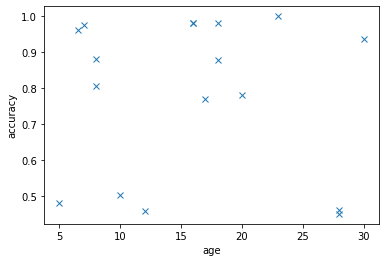

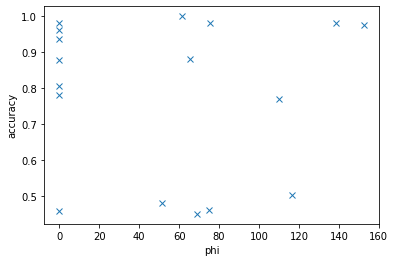

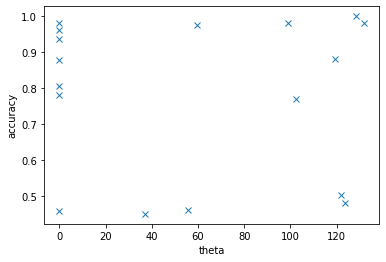

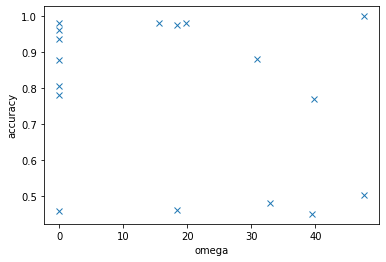

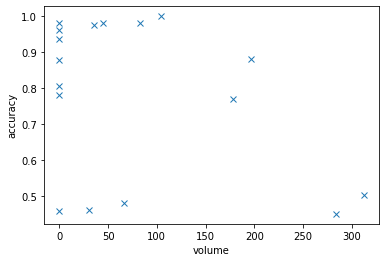

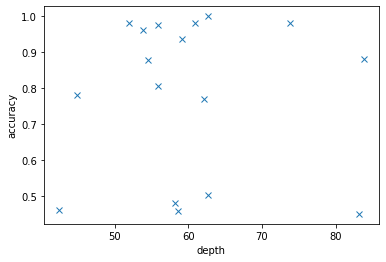

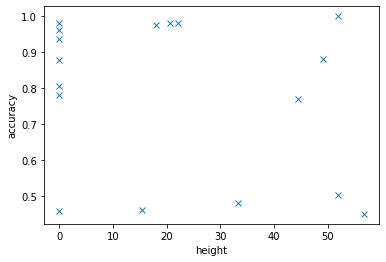

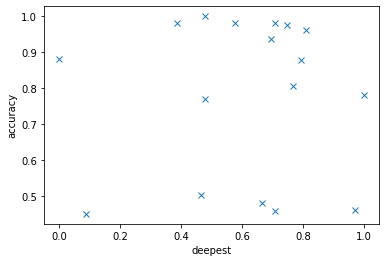

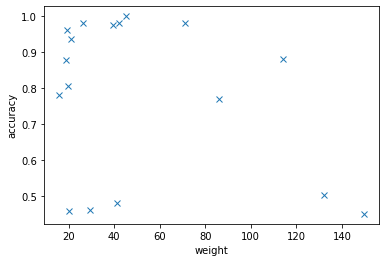

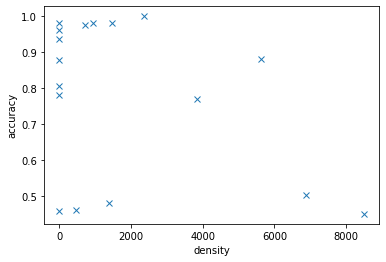

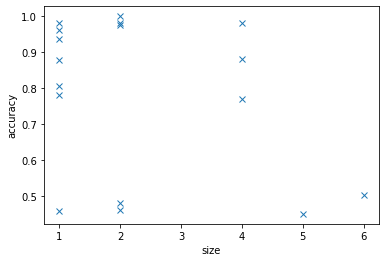

In [48]:
dfplot(df, 'age', 'accuracy', 'x')
dfplot(df, 'phi', 'accuracy', 'x')
dfplot(df, 'theta', 'accuracy', 'x')
dfplot(df, 'omega', 'accuracy', 'x')
dfplot(df, 'volume', 'accuracy', 'x')
dfplot(df, 'depth', 'accuracy', 'x')
dfplot(df, 'height', 'accuracy', 'x')
dfplot(df, 'deepest', 'accuracy', 'x')
dfplot(df, 'weight', 'accuracy', 'x')
dfplot(df, 'density', 'accuracy', 'x')
dfplot(df, 'size', 'accuracy', 'x')

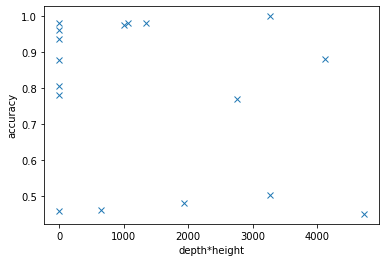

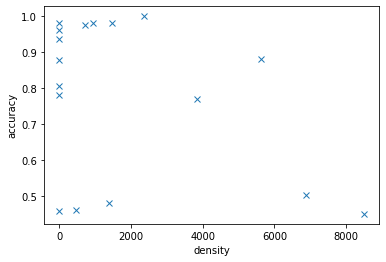

In [47]:
p = df['depth'].to_numpy() * df['height'].to_numpy()
plt.plot(p, df['accuracy'].to_numpy(), 'x')
plt.xlabel('depth*height')
plt.ylabel('accuracy')
plt.show()
dfplot(df, 'density', 'accuracy', 'x')

In [19]:
sep = '\n\n*****************\n'
print(sep)
for param in [
    'engel',
    'hemisphere',
    'sex',
    'age',
    'omega',
    'phi',
    'theta',
    'volume',
    'density',
    'height',
    'weight',
    'size',
    'deepest',
    'depth'
]:

    s_corr, s_p = spearmanr(df[param].to_numpy(), df['accuracy'].to_numpy())
    p_corr, p_p = pearsonr(df[param].to_numpy(), df['accuracy'].to_numpy())
    print(f'Correlation between {param} and accuracy\n'
          f'SpearmannCorrCoef: {s_corr}\nSpearmann p-val: {s_p}\n'
          f'PearsonCorrCoef: {p_corr}\nPearson p-val: {p_p}{sep}')



*****************

Correlation between engel and accuracy
SpearmannCorrCoef: 0.0
Spearmann p-val: 1.0
PearsonCorrCoef: 0.18220683067063703
Pearson p-val: 0.48397180072519336

*****************

Correlation between hemisphere and accuracy
SpearmannCorrCoef: 0.0
Spearmann p-val: 1.0
PearsonCorrCoef: 0.04589477250827872
Pearson p-val: 0.8611530398330463

*****************

Correlation between sex and accuracy
SpearmannCorrCoef: 0.1924500897298753
Spearmann p-val: 0.45929242729052266
PearsonCorrCoef: 0.11650960897664386
Pearson p-val: 0.6560936976394461

*****************

Correlation between age and accuracy
SpearmannCorrCoef: -0.04668318759321833
Spearmann p-val: 0.8587901008710948
PearsonCorrCoef: -0.05945913359674733
Pearson p-val: 0.8206706662597498

*****************

Correlation between omega and accuracy
SpearmannCorrCoef: -0.07619024583482795
Spearmann p-val: 0.7713306932718502
PearsonCorrCoef: -0.2895179762404799
Pearson p-val: 0.2596828706108507

*****************

Correlation

In [ ]:
for param in ['age', 'size', 'deepest', 'weight']:
    s_corr, s_p = spearmanr(df[param].to_numpy(), df['engel'].to_numpy())
    p_corr, p_p = pearsonr(df[param].to_numpy(), df['engel'].to_numpy())
    print(f'Correlation between {param} and engel\n'
          f'SpearmannCorrCoef: {s_corr}\nSpearmann p-val: {s_p}\n'
          f'PearsonCorrCoef: {p_corr}\nPearson p-val: {p_p}{sep}')

In [ ]:
X = np.array([
    [d, a]
    for d, a in zip(
        df['deepest'].to_numpy(),
        df['age'].to_numpy()
    )
])
y = df[['accuracy']].to_numpy()

reg = LinearRegression().fit(X, y)


print('Linear model for depth and age to accuracy')
print(f'score: {reg.score(X, y)}')
print(f'coef: {reg.coef_}')
# intercept is the expected mean value when X=0
print(f'intercept: {reg.intercept_}')

In [41]:
X = np.array([
    [
        depth,
        # deepest, #0
        # size, #0
        weight, #*
        age,
        engel, #0
        # sex,
        phi,
        theta,
        omega, #*
        height,
        density, #*
        volume,
        # hemisphere
    ]
    for depth,
        deepest,
        size,
        weight,
        age,
        engel,
        sex,
        phi,
        theta,
        omega,
        height,
        density,
        volume,
        hemisphere in zip(
        df['depth'].to_numpy(),
        df['deepest'].to_numpy(),
        df['size'].to_numpy(),
        df['weight'].to_numpy(),
        df['age'].to_numpy(),
        df['engel'].to_numpy(),
        df['sex'].to_numpy(),
        df['phi'].to_numpy(),
        df['theta'].to_numpy(),
        df['omega'].to_numpy(),
        df['height'].to_numpy(),
        df['density'].to_numpy(),
        df['volume'].to_numpy(),
        df['hemisphere'].to_numpy(),
    )
])
y = df[['accuracy']].to_numpy()

reg = LinearRegression()
y = [val[0] for val in y]

reg.fit(X, y)

print('Linear model for accuracy')
print(f'score: {reg.score(X, y): .2f}')
# print(f'coef: {reg.coef_}')
# print(f'intercept: {reg.intercept_}')

Linear model for accuracy
score:  0.76


In [39]:
X = np.array([
    [
        depth,
        deepest,
        size,
        weight,
        age,
        sex,
        phi,
        theta,
        omega,
        height,
        density,
        # accuracy,
        volume,
        hemisphere
    ]
    for depth,
        deepest,
        size,
        weight,
        age,
        sex,
        phi,
        theta,
        omega,
        height,
        density,
        accuracy,
        volume,
        hemisphere in zip(
        df['depth'].to_numpy(),
        df['deepest'].to_numpy(),
        df['size'].to_numpy(),
        df['weight'].to_numpy(),
        df['age'].to_numpy(),
        df['sex'].to_numpy(),
        df['phi'].to_numpy(),
        df['theta'].to_numpy(),
        df['omega'].to_numpy(),
        df['height'].to_numpy(),
        df['density'].to_numpy(),
        df[['accuracy']].to_numpy(),
        df['volume'].to_numpy(),
        df['hemisphere'].to_numpy(),
    )
])
y = df[['engel']].to_numpy()
y = [val[0] for val in y]
reg = LinearRegression().fit(X, y)

print('Linear model for engel')
print(f'score: {reg.score(X, y)}')
# print(f'coef: {reg.coef_}')
# print(f'intercept: {reg.intercept_}')




Linear model for engel
score: 0.8987162543328111
